### Objective: To forecast the sales of different products in various stores for the next three months.

### Description

This Kaggle competition is provided as a way to explore different **Time Series Techniques** on a relatively simple and clean dataset.

It is given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting.


### Dataset Story

The objective of this competition is to predict 3 months of item-level sales data at different store locations.

#### File descriptions
    
- **train.csv**: - Training data
- **test.csv**: - Test data (Note: the Public/Private split is time based)
- **sample_submission.csv**: - a sample submission file in the correct format


#### Data fields
    
- **date**: Date of the sale data. There are no holiday effects or store closures.
- **store**: Store ID - 10 different store
- **item**:Item ID - 50 different items
- **sales**: Number of items sold at a particular store on a particular date.


In [1]:
# Import library and modules

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [2]:
# Load dataset

# parse_dates=['date'] -- Convert the date column into a datetime format instead of treating it as a regular string.


train = pd.read_csv('train.csv', parse_dates=['date'])

test = pd.read_csv('test.csv', parse_dates=['date'])

sample_sub = pd.read_csv('sample_submission.csv')

In [3]:
## check train datasets

train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
## check test datasets

test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


**The test dataset does not contain a sales column. Therefore, we are expected to predict how much of each product will be sold in each store on the given dates based on the provided IDs, which include store and item breakdowns.**

In [5]:
# Combines two DataFrames

# I merged the datasets for efficient preprocessing and feature engineering in time series modeling. 
# This prevents class discrepancies and dimensional mismatches while minimizing data leakage risks.

# sort=False -- Ensures that column order remains the same instead of sorting them alphabetically.

df = pd.concat([train, test], sort=False)

In [6]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


#### 1) EDA- Exploratory Data Analysis

In [7]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [8]:
 check_df(train, head=5)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
##################### Tail #####################
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
                      0.00                 0.05                 0.50                 0.95       

In [9]:
 check_df(test, head=5)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
##################### Tail #####################
          id       date  store  item
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64
##################### Quantiles #####################
                      0.00                 0.05                 0.50                 0.95                 0.99           

In [10]:
 check_df(df, head=5)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

The reason for NAN values in the ID column is that the train set does not contain an id column. Only test dataset has it.

The reason for NAN values in the SALES column is that the test set does not contain an id column.It needs to be predicted.

The 45,000 NA values in the Sales column are because the test set, which has a size of 45,000, does not include the Sales column.

The 913,000 NA values ​​in the id column are due to the train set which has a size of 913,000, does not include the id column.

In [11]:
# Finds the earliest (min) and latest (max) dates in the dataset.

df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

- **Train datasets- 2013-01-01-2017-12-31**
- **Test datasets - 2018-01-01-2018-03-31**

In [12]:
# Counts the number of unique ITEMS in the dataset.

df[["item"]].nunique()

item    50
dtype: int64

In [13]:
# Counts the number of unique STORES in the dataset.

df[["store"]].nunique()

store    10
dtype: int64

In [14]:
# Counts the number of unique items in the STORE.

df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

Each store has 50 unique items.

In [15]:
# Counts how many unique items are sold in each store.

df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [16]:
# Computes total (sum), average (mean), median, and standard deviation (std) of sales per store-item pair.

df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})


sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

#### 2)FEATURE ENGINEERING

In [17]:
# The operations in the dataset aimed at capturing seasonality.

def create_date_features(df):
    df['month'] = df.date.dt.month  # Extract the month
    df['day_of_month'] = df.date.dt.day  # Extract the day of the month
    df['day_of_year'] = df.date.dt.dayofyear  # Extract the day of the year
    df['week_of_year'] = df.date.dt.isocalendar().week  # Extract the week number of the year
    df['day_of_week'] = df.date.dt.dayofweek  # Extract the day of the week (Monday=0, Sunday=6)
    df['year'] = df.date.dt.year  # Extract the year
    df["is_wknd"] = df.date.dt.weekday // 4  # Mark weekends (1 for Sat/Sun, 0 for weekdays)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)  # Check if it's the first day of the month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)  # Check if it's the last day of the month
    return df


In [18]:
df = create_date_features(df)

In [19]:
check_df(df)

##################### Shape #####################
(958000, 14)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int32
is_month_end               int32
dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0 2013-01-01      1     1   13.0 NaN      1             1            1             1            1  2013        0               1             0
1 2013-01-02      1     1   11.0 NaN      1             2            2      

In [20]:
# Step 1: Convert 'week_of_year' to 'int32'
df['week_of_year'] = df['week_of_year'].astype('int32')

# Step 2: Verify the data type
print(df['week_of_year'].dtype)  # Should output: int32

int32


In [21]:
# Computes total (sum), average (mean), median, and standard deviation (std) of sales per store-item pair by month

df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

### Random Noise

The lag features to be created will be based on the dependent variable, i.e., the sales column. To prevent overfitting after this process, random noise will be added to the dataset with the same dimensions as the dataframe. This will help preserve randomness and avoid overfitting.

This function creates **a normal distribution of random values (noise)** with a standard deviation of 1.6. 

It returns an array of **noise with the same length as the dataframe**, which could be added as a feature or used for testing purposes in the dataset.

**scale=1.6:** Specifies the standard deviation of the noise. A higher scale results in more variability in the noise.

**size=(len(dataframe)**: Ensures that the noise array has the same length as the dataframe, so it can be applied to the data.


In [22]:
#  Create a function

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

### Lag/Shifted Features

To create features based on past sales figures.

In [23]:
## Generate the values ​​of the sales variable in previous periods, the data needs to be sorted.

df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [24]:
## pd.DataFrame({"sales": df["sales"].values[0:10],
#              "lag1": df["sales"].shift(1).values[0:10],
#              "lag2": df["sales"].shift(2).values[0:10],
#              "lag3": df["sales"].shift(3).values[0:10],
#              "lag4": df["sales"].shift(4).values[0:10]})

##df.groupby(["store", "item"])['sales'].head()

## df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))

In [25]:
# This function creates lagged features for the sales data in a time series format.


def lag_features(dataframe, lags):  # Define the function to create lag features based on the given lags
    for lag in lags:  # Loop through each value in the 'lags' list
        # Create a new column for each lag (sales_lag_1, sales_lag_2, etc.)
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            # Group the data by 'store' and 'item' to calculate lags per store-item combination
            lambda x: x.shift(lag)) + random_noise(dataframe)  # Shift the sales by the given lag and add random noise
    return dataframe  # Return the modified dataframe with the lag features


In [26]:
#  aim to make forecasts for a 3-month horizon, the features generated have been computed based on 3-month intervals and their respective multiples.

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [27]:
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year               int32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int32
is_month_end               int32
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

- **Since there is no observation 90 days prior to 2013-01-01, sales_lag_91 column contains NA values. etc.**
- **Since a tree-based method is used, negative values can be ignored..**

### Rolling Mean Features

**Key Point:** When using the rolling method to capture past trends, the average calculation includes the current observation itself, making it unsuitable for accurately identifying trends.

After taking the shift, rolling mean features need to be produced.

In [28]:
### Example
#pd.DataFrame({"sales": df["sales"].values[0:10],
#              "roll2": df["sales"].rolling(window=2).mean().values[0:10],
#              "roll3": df["sales"].rolling(window=3).mean().values[0:10],
#              "roll5": df["sales"].rolling(window=5).mean().values[0:10]})

#pd.DataFrame({"sales": df["sales"].values[0:10],
#              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
#              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
#              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})
### 

In [29]:
# This function creates rolling mean features for different window sizes to capture trends in past sales while preventing data leakage

# shift(1) → Ensures the rolling mean does not include the current observation (avoiding data leakage).
# window=window → Defines the number of periods for the moving average.
# min_periods=10 → Requires at least 10 observations to compute a value.
# win_type="triang" → Uses a triangular weighting for smoothing.
# random_noise(dataframe) → Adds noise to prevent overfitting.


def roll_mean_features(dataframe, windows):  # Define function to create rolling mean features
    for window in windows:  # Loop through each window size in the list
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
            transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()
            ) + random_noise(dataframe)  # Compute rolling mean after shifting and add random noise
    return dataframe  # Return modified dataframe


In [30]:
# The moving average of the sum of all values from 1 year and one 1,5 prior to the first forecasted time period.

df = roll_mean_features(df, [365, 546])

### Exponentially Weighted Mean Features (EWM)

- EWM is useful in time series forecasting, particularly when recent observations are more influential in predicting future values.

- α (smoothing factor): Determines how much weight recent values receive.

In [31]:
# This function creates exponentially weighted mean (EWM) features for different smoothing factors (alphas) and lags (lags).

def ewm_features(dataframe, alphas, lags):  # Define function to create EWM features
    for alpha in alphas:  # Loop through smoothing factors (alphas)
        for lag in lags:  # Loop through lag values
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(
                    lambda x: x.shift(lag).ewm(alpha=alpha).mean())  # Compute EWM on lagged sales
    return dataframe  # Return modified dataframe




In [32]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]

lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

In [33]:
df = ewm_features(df, alphas, lags)

### 3) PREPARATION MODEL 

#### One-Hot Encoding

In [34]:
# Converts categorical variables ('store', 'item', 'day_of_week', 'month') into one-hot encoded binary columns.

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

#### Log of Dependent Variable

In general, log transformation is beneficial when dealing with data that has a skewed distribution, outliers, or exponential growth patterns.
Log transformations are typically only applied to continuous numerical data, not categorical data.

- **Linear Models:** Log transformation improves model assumptions.
- 
- **Tree-based Models:** Not required, but can improve stability and handle outliers. Decision Tree,Random Forest,Gradient Boosting,XGBoost,LightGBM,CatBoost
- 
- **Neural Networks:** Helps normalize data and improve performance.
- 
- **SVM and k-NN:** Reduces sensitivity to outliers.


- np.log1p() is used to apply a logarithmic transformation to the sales column to handle skewed data and prevent issues with zero values.

- It helps normalize data for better predictive model performance, especially with features that have exponential growth.
  
- Log transformation is typically used to reduce skewness in data and make it more normally distributed

In [35]:
## Using LightGBM model and  make model fast training

df['sales'] = np.log1p(df["sales"].values)

### Custom Cost Function

Which Metric to Use?

These are error metrics used to evaluate the performance of regression models by comparing predicted values with actual values.

- **MAE →** If all errors should be treated equally.
- **MSE / RMSE →** If large errors should be penalized more (e.g., forecasting). MSE-More sensitive to outliers than MAE.
- **MAPE →** If you need percentage-based evaluation, but beware of zero values.
- **SMAPE →** A better alternative to MAPE, especially for datasets with zero values.

In [36]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [37]:
# This function calculates SMAPE (Symmetric Mean Absolute Percentage Error) for LightGBM predictions.

def lgbm_smape(preds, train_data):  # Define a custom evaluation function for LightGBM using SMAPE
    labels = train_data.get_label()  # Get the true labels from the training data
    smape_val = smape(np.expm1(preds), np.expm1(labels))  # Convert log-transformed values back & calculate SMAPE
    return 'SMAPE', smape_val, False  # Return the metric name, computed value, and a flag (False means lower is better)



### Time-Based Validation Sets

In [38]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [39]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


##### Train dataset

In [40]:
# The training set includes data up until the end of 2016 (until the beginning of 2017).

train = df.loc[(df["date"] < "2017-01-01"), :]

In [41]:
# The first three months of 2017 are the validation set.

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [42]:
# Uses list comprehension to filter out unwanted columns.

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [43]:
## Choosing dependent variables for train dataset
Y_train = train['sales']

## Choosing in dependent variables for train dataset

X_train = train[cols]

##### Validaton Datasaet

In [44]:
## Choosing dependent variables for validation dataset
Y_val = val['sales']

## Choosing independent variables for validation dataset
X_val = val[cols]

In [45]:
## Check shape all datasets

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

### 4) MODELLING 

### TIMES SERISES MODEL WITH LIGHTGBM

In [49]:
# LightGBM parameters


# After generating hyperparameter combinations using the GridSearchCV method, optimal values have been determined.
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

# early_stopping_rounds : If the metric in the validation set does not improve within a certain early_stopping_rounds, stop the modeling process. 
# This both shortens the training time and prevents overfitting.
# learning_rate: shrinkage_rate, eta
# num_boost_round: n_estimators, number of boosting iterations. At least around 10.000-15.000
# nthread: num_thread, nthread, nthreads, n_jobs

In [47]:
# Create LightGBM Datasets

# Creates a LightGBM training dataset using X_train as features and Y_train as labels.
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

# Creates a validation dataset (lgbval) with X_val and Y_val.
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)



In [50]:
# Train the LightGBM model with early stopping
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=500)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.673156 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[500]	training's l2: 0.0306718	training's SMAPE: 13.6578	valid_1's l2: 0.0326293	valid_1's SMAPE: 14.1479
[1000]	training's l2: 0.0291285	training's SMAPE: 13.3451	valid_1's l2: 0.0312976	valid_1's SMAPE: 13.8285
[1500]	training's l2: 0.028458	training's SMAPE: 13.2044	valid_1's l2: 0.0308374	valid_1's SMAPE: 13.7159
[2000]	training's l2: 0.0281213	training's SMAPE: 13.1293	valid_1's l2: 0.0306223	valid_1's SMAPE: 13.6629
[2500]	training's l2: 0.027886	training's SMAPE: 13.0771	valid_1's l2: 0.0304903	valid_1's SMAPE: 13.6309
[3000]	training's l2: 0.0277067	training's SMAPE: 13.0378	valid_1's l2: 0.0304022	valid_1's SMAPE: 13.6083
[3500]	training's l2: 0.0275552	training's SMAPE: 13.0055	valid_1's l2: 0.0303335	valid_1's SMAPE: 13.5912
[4000]	training's l2: 0.027

In [51]:
# Making predictions on the validation set (X_val).
# model refers to the trained LightGBM model (i.e., the booster object).
# X_val is the validation dataset (features only, no target variable) for which you want to make predictions.


y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [52]:
# EXPM1 of code calculates the SMAPE metric between the predicted values (y_pred_val) and actual values (Y_val)
# after both have been converted back from the log-transformed scale .

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.5327765104848

### FEATURE IMPORTANCE

In [53]:
# This function either prints or plots the top features by gain importance in a LightGBM model.

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

In [54]:
plot_lgb_importances(model, num=30)

                         feature  split       gain
17           sales_roll_mean_546   6164  53.880253
13                 sales_lag_364   5409  13.230733
16           sales_roll_mean_365   4508   9.864441
60    sales_ewm_alpha_05_lag_365   1511   4.837892
18    sales_ewm_alpha_095_lag_91    880   2.716138
1                    day_of_year   4579   2.081788
54     sales_ewm_alpha_05_lag_91    855   1.860860
3                        is_wknd    719   1.189350
123                day_of_week_0    623   1.172087
141                     month_12    882   1.142223
2                   week_of_year   1307   0.994004
36     sales_ewm_alpha_08_lag_91    384   0.892858
6                   sales_lag_91   1325   0.820643
27     sales_ewm_alpha_09_lag_91    442   0.664164
7                   sales_lag_98    901   0.544961
62    sales_ewm_alpha_05_lag_728   1457   0.411757
44    sales_ewm_alpha_08_lag_728    323   0.402445
59    sales_ewm_alpha_05_lag_270   1420   0.361558
51    sales_ewm_alpha_07_lag_36

,feature,split,gain
17,sales_roll_mean_546,6164,53.880253
13,sales_lag_364,5409,13.230733
16,sales_roll_mean_365,4508,9.864441
60,sales_ewm_alpha_05_lag_365,1511,4.837892
18,sales_ewm_alpha_095_lag_91,880,2.716138
...,...,...,...
98,item_26,20,0.000190
4,is_month_start,17,0.000188
133,month_4,19,0.000170
81,item_9,19,0.000117


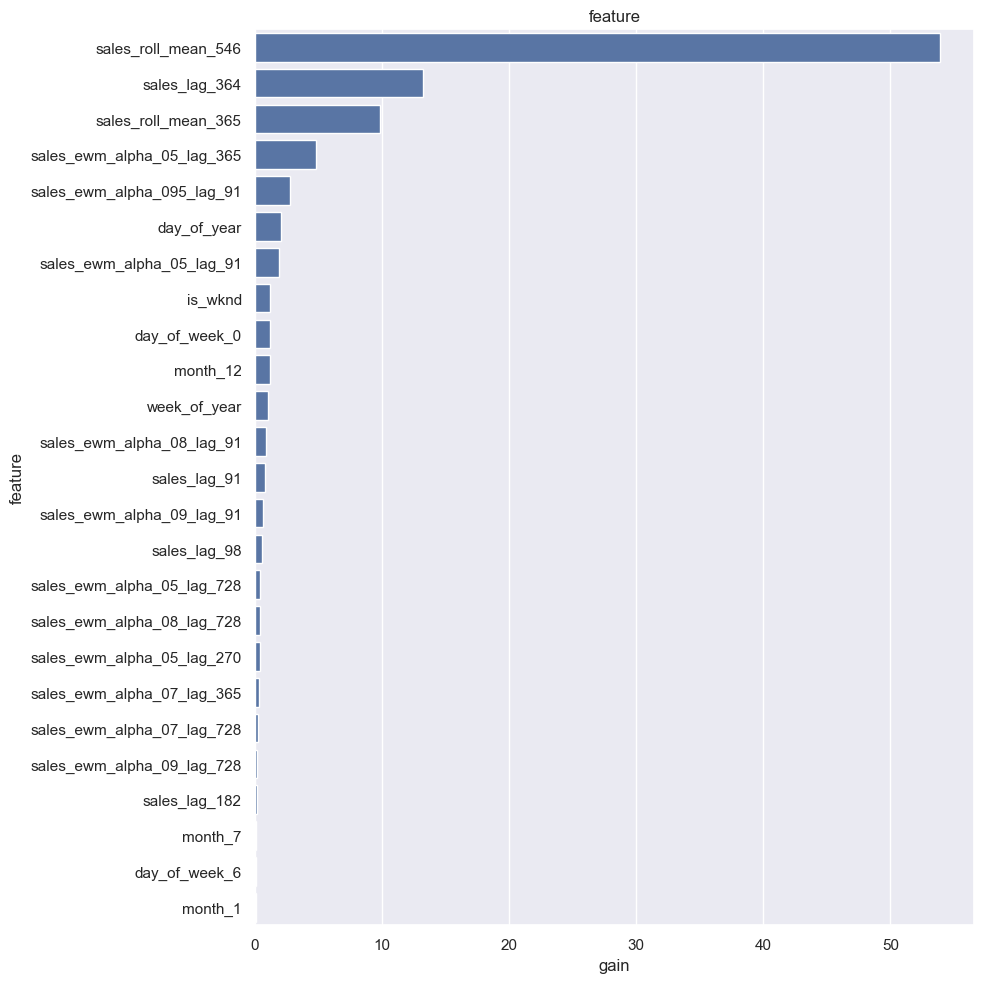

,feature,split,gain
17,sales_roll_mean_546,6164,53.880253
13,sales_lag_364,5409,13.230733
16,sales_roll_mean_365,4508,9.864441
60,sales_ewm_alpha_05_lag_365,1511,4.837892
18,sales_ewm_alpha_095_lag_91,880,2.716138
...,...,...,...
98,item_26,20,0.000190
4,is_month_start,17,0.000188
133,month_4,19,0.000170
81,item_9,19,0.000117


In [55]:
plot_lgb_importances(model, num=30, plot=True)

In [56]:
feat_imp = plot_lgb_importances(model, num=200)

                        feature  split       gain
17          sales_roll_mean_546   6164  53.880253
13                sales_lag_364   5409  13.230733
16          sales_roll_mean_365   4508   9.864441
60   sales_ewm_alpha_05_lag_365   1511   4.837892
18   sales_ewm_alpha_095_lag_91    880   2.716138
..                          ...    ...        ...
98                      item_26     20   0.000190
4                is_month_start     17   0.000188
133                     month_4     19   0.000170
81                       item_9     19   0.000117
120                     item_48      1   0.000004

[142 rows x 3 columns]


In [57]:
importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

In [58]:
imp_feats = [col for col in cols if col not in importance_zero]

In [59]:
len(imp_feats)

142

### FINAL MODEL

In [60]:
# Train dataset where the sales column has not missing (NaN).

train = df.loc[~df.sales.isna()]

Y_train = train['sales']

X_train = train[imp_feats]


# Test dataset where the sales column has Nan values

test = df.loc[df.sales.isna()]

X_test = test[imp_feats]

In [61]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [62]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=imp_feats)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.900139 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [63]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

##### Submission File

In [64]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,8.417639,15.233774,23.438231,16.472803,11.164397,17.025342,19.333026,13.152382,18.044373,12.115748,24.464577,20.402727,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,18.981505,18.465957,20.645759,17.521429,25.061545,19.834977,20.658003,9.112043,31.362901,11.781092,26.818299,21.806028,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [65]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df

,id,sales
0,0.0,NaN
1,1.0,NaN
2,2.0,NaN
3,3.0,NaN
4,4.0,NaN
...,...,...
44995,44995.0,NaN
44996,44996.0,NaN
44997,44997.0,NaN
44998,44998.0,NaN


In [66]:
submission_df['sales'] = np.expm1(test_preds)

In [67]:
submission_df

,id,sales
0,0.0,11.731891
1,1.0,14.069065
2,2.0,14.317144
3,3.0,14.409173
4,4.0,16.752055
...,...,...
44995,44995.0,72.061240
44996,44996.0,75.656343
44997,44997.0,78.927069
44998,44998.0,83.187843


In [68]:
submission_df['id'] = submission_df.id.astype(int)

In [69]:
submission_df.to_csv("submission_demand.csv", index=False)